In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [5]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [6]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [7]:
class NeuralNet:
    
    def __init__(self, layers_sizes, normalize = True, learning_rate = 0.01, num_iter = 15000, costs_iters=300, tol=1e-7):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layers_sizes = layers_sizes
        self.tol = tol
        self.layers = len(layers_sizes) + 1
        self.costs_iters = costs_iters
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __sigmoid_derivative(self, A):
        return np.multiply(A, 1 - A)
    
    def __initialize_parameters(self):
        W, b = [], []
        
        for l in range(1,self.layers+1):
            W_l = np.random.randn(self.layers_sizes[l], self.layers_sizes[l-1]) * 0.01
            b_l = np.zeros((self.layers_sizes[l], 1))
            W.append(W_l)
            b.append(b_l)
        
        self.parameters = {"W" : W, "b" : b}
         
        for key in self.parameters:
            for key_i,i in zip(self.parameters[key],range(len(self.parameters[key]))):
                print("{}{}: {}".format(key,i+1,key_i.shape))
       
    def __forward_propagation(self, X):            
        W = self.parameters["W"]
        b = self.parameters["b"]
        Z, A = [], [] 

        A.append(X)
        for l in range(0,self.layers):
            Z_l = np.dot(W[l],A[l]) + b[l]
            A_l = self.__sigmoid(Z_l)
            Z.append(Z_l)
            A.append(A_l)
        
        cache = (Z,A)
        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        
        W = self.parameters["W"]
        b = self.parameters["b"]
        (Z,A) = cache
        
        dZ, dW, db = [], [], []
        
        dZ_l = A[-1] - Y
        dW_l = 1. / m * np.dot(dZ_l, A[-2].T)
        db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
        
        dZ.insert(0,dZ_l)
        dW.insert(0,dW_l)
        db.insert(0,db_l)
        
        for l in range(self.layers-1,0,-1):
            dA_l = np.dot(W[l].T,dZ_l)
            dZ_l = np.multiply(dA_l, self.__sigmoid_derivative(A[l]))
            dW_l = 1. / m * np.dot(dZ_l, A[l-1].T)
            db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
            dZ.insert(0,dZ_l)
            dW.insert(0,dW_l)
            db.insert(0,db_l)
        
        grads = {"dZ":dZ,"dW":dW,"db":db}
        return grads
  
    
    def __update_parameters(self, grads):        
        W = self.parameters["W"]
        b = self.parameters["b"]
        dW = grads["dW"]
        db = grads["db"]
    
        for l in range(0,len(W)):
            W[l] = W[l] - self.learning_rate * dW[l]
            b[l] = b[l] - self.learning_rate * db[l]
            
        self.parameters["W"] = W
        self.parameters["b"] = b

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        costs_imp = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.layers_sizes.insert(0,n_x)
        self.layers_sizes.append(1);
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            
            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
            
            costs_imp.append(cost)
            if i > self.costs_iters:
                len_imp = len(costs_imp)-1
                if abs(costs_imp[len_imp] - costs_imp[len_imp-self.costs_iters]) < self.tol:
                    print("Stop iteration: {}".format(i))
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
                
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)


In [8]:
#задача
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X2, Y2 = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X2.shape, Y2.shape))

Training set: X=(118, 2), y=(118, 1)


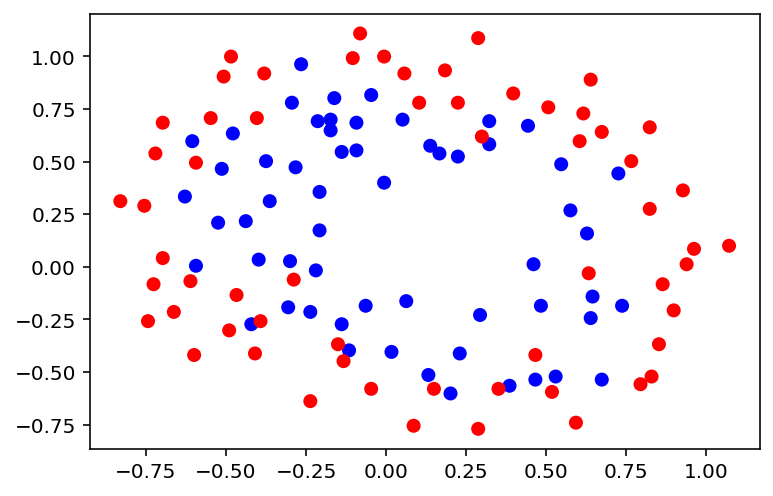

In [9]:
plot_data(X2, Y2)

In [10]:
cls = NeuralNet(layers_sizes = [70,60], normalize = True, learning_rate = 0.5, num_iter = 20001, tol = 1e-7, costs_iters=500)


W1: (70, 2)
W2: (60, 70)
W3: (1, 60)
b1: (70, 1)
b2: (60, 1)
b3: (1, 1)
0-th iteration: 0.6936094536712771


1000-th iteration: 0.6930029998195797


2000-th iteration: 0.6930025219037513


3000-th iteration: 0.6930018691854721


4000-th iteration: 0.6930008904093738


5000-th iteration: 0.692999294086579


6000-th iteration: 0.6929964498546598


7000-th iteration: 0.6929908037619288


8000-th iteration: 0.692977809123195


9000-th iteration: 0.6929404455932135


10000-th iteration: 0.692785339665225


11000-th iteration: 0.6924234639296318


12000-th iteration: 0.6898800669966672


13000-th iteration: 0.6879062358456955


14000-th iteration: 0.6349110530581443


15000-th iteration: 0.5716753604260014


16000-th iteration: 0.548606765411429


17000-th iteration: 0.5425347457323624


18000-th iteration: 0.5406175570733156


19000-th iteration: 0.5314349985443564


20000-th iteration: 0.40285430188014065


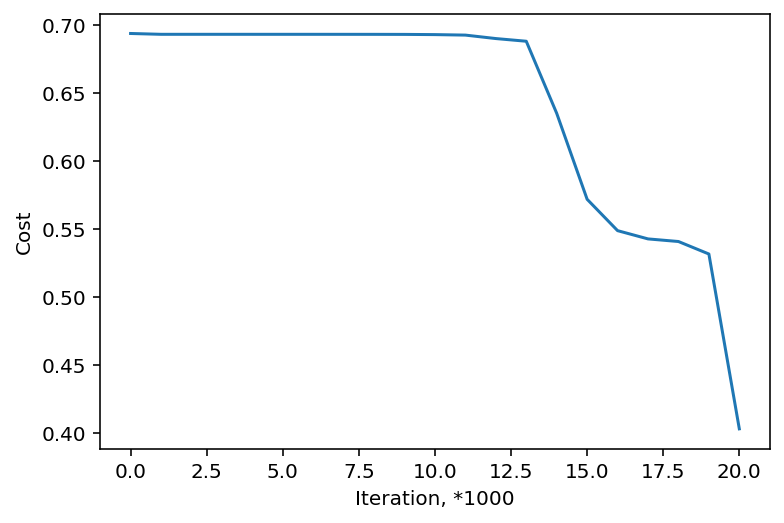

In [12]:
cls.fit(X2, Y2)

In [14]:
for key in cls.parameters:
    print("{}:\n".format(key))
    for i in cls.parameters[key]:
        print("{}\n".format(i))

W:

[[ 0.94911435  0.47831024]
 [-0.08012762  0.70141616]
 [-0.01878394  0.59162912]
 [-0.61193304 -0.72968224]
 [ 0.11971513  0.64718628]
 [ 0.52778987  0.5618976 ]
 [ 0.44074505 -0.91733931]
 [-0.54612137 -0.73709486]
 [ 1.06977486  0.53908915]
 [ 0.61871406 -0.54463701]
 [-0.39875708 -0.74723072]
 [ 0.53435506  0.39286438]
 [-0.33182679 -0.73479036]
 [-0.54806377 -0.71144865]
 [-0.36529261  0.71509449]
 [-0.80668494  0.67264206]
 [ 0.30384543 -0.86402126]
 [ 0.25578689 -0.92366341]
 [-0.68568741 -0.74583484]
 [ 1.09714223  0.56045147]
 [ 0.07138409  0.67110723]
 [ 0.58156376 -0.91939442]
 [-0.63161063 -0.70265639]
 [-0.60789648 -0.92844341]
 [-0.66061348 -0.83003911]
 [-0.21731408  0.62655744]
 [ 0.50201004 -0.81707593]
 [ 0.82985701  0.46361687]
 [ 0.76742733  0.46696401]
 [ 0.88551254  0.48635701]
 [-0.22444551 -0.76979389]
 [-0.22729009  0.07191506]
 [ 1.12302264  0.66644763]
 [ 1.12249089  0.6705897 ]
 [ 0.42903853  0.46452279]
 [ 0.98557562  0.51595457]
 [ 0.71046151 -0.5843557

In [15]:
Y2_prob = cls.predict_proba(X2)
Y2_prob

array([[0.88493901, 0.11506099],
       [0.81708838, 0.18291162],
       [0.87636477, 0.12363523],
       [0.77497858, 0.22502142],
       [0.63857944, 0.36142056],
       [0.73044772, 0.26955228],
       [0.78358326, 0.21641674],
       [0.59890215, 0.40109785],
       [0.80095248, 0.19904752],
       [0.71489574, 0.28510426],
       [0.60882998, 0.39117002],
       [0.49996596, 0.50003404],
       [0.52412293, 0.47587707],
       [0.37634654, 0.62365346],
       [0.78842683, 0.21157317],
       [0.86159737, 0.13840263],
       [0.93355295, 0.06644705],
       [0.48899404, 0.51100596],
       [0.87715721, 0.12284279],
       [0.70553423, 0.29446577],
       [0.53665173, 0.46334827],
       [0.64116616, 0.35883384],
       [0.21602907, 0.78397093],
       [0.1426254 , 0.8573746 ],
       [0.58414308, 0.41585692],
       [0.59727053, 0.40272947],
       [0.53656498, 0.46343502],
       [0.40997999, 0.59002001],
       [0.91251931, 0.08748069],
       [0.81140636, 0.18859364],
       [0.

In [16]:
Y2_hat = cls.predict(X2)
Y2_hat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1])

In [17]:
accuracy_score(Y2, Y2_hat)

0.8220338983050848

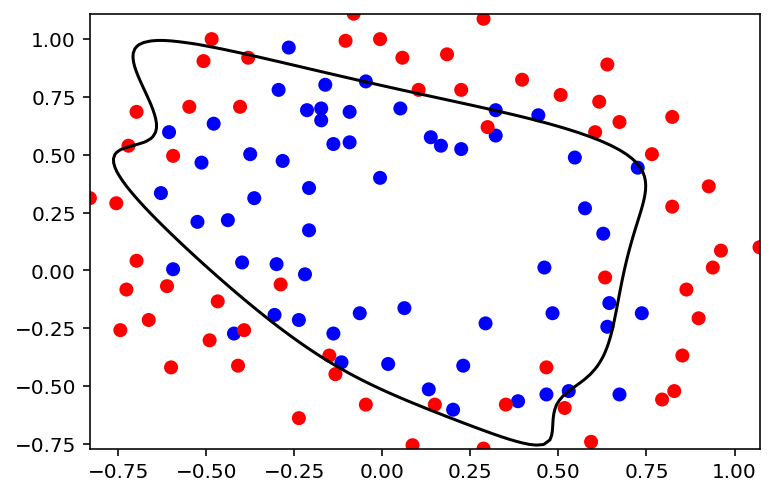

In [19]:
plot_data(X2, Y2)
plot_surface(cls, X2[:, 0], X2[:, 1])

In [21]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,20), max_iter = 20001, solver = 'adam', activation = 'relu')

In [22]:
clf.fit(X2, Y2)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=20001)

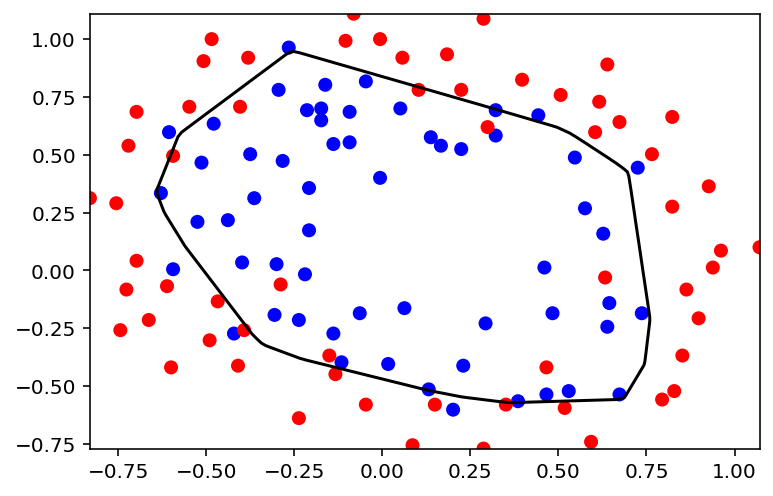

In [23]:
plot_data(X2, Y2)
plot_surface(clf, X2[:, 0], X2[:, 1])

In [24]:
accuracy_score(Y2, clf.predict(X2))

0.8728813559322034

In [25]:
clf.n_iter_

604